# Adaptive Echo Cancellation

In this notebook we will use the adaptive LMS filter to estimate the impulse response of a communication channel that introduces multiples echos. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as sp
import IPython
from scipy.io import wavfile

In [2]:
plt.rcParams["figure.figsize"] = (14,4)

We will compare the convergence properties of the LMS algorithm both for noise-like signals and for voice signals. Let's load a brief speech telephone-quality sample that we will use in the following. 

In [4]:
Fs, s = wavfile.read('speech2.wav')
s = s / 32767.0 # scale the signal to floats in [-1, 1]
print('sampling rate:', Fs, 'Hz, data length:', len(s), 'samples')
IPython.display.Audio(s, rate=Fs)

sampling rate: 8000 Hz, data length: 19063 samples


Also, a little helper function to generate a $\delta[n]$ signal:

In [5]:
def delta(N):
    d = np.zeros(N)
    d[0] = 1
    return d

We will use a recursive model for the echo generation in which each reflection is flipped in sign, attenuated and lowpass filtered with a simple one-pole lowpass. 

<img width="750" style="margin: 10px 20px 0 0;" src="echo.jpg">

In the above block diagram, $M$ is the echo's delay, $-1 < \alpha < 0$ is the attenuation factor for each repetition and $H(z) = (1-\lambda)/(1 - \lambda z^{-1})$ is a simple leaky integrator with $\lambda$ relatively small in order to just attenuate more and more the signal with each reflection.

The CCDE governing the system turns out to be 

$$
    y[n] = x[n] − \lambda x[n − 1] + \lambda y[n − 1] + \alpha (1 − \lambda)y[n − M]
$$

In [7]:
def echo(x, M, lmb=0.6, alpha=-0.8):
    y = np.zeros(len(x))
    for n in range(0, len(x)):
        if n >= M:
            y[n] = x[n] - lmb * x[n-1] + lmb * y[n-1] + alpha * (1 - lmb) * y[n - M]
        elif n > 0:
            y[n] = x[n] - lmb * x[n-1] + lmb * y[n-1]
        else:
            y[n] = x[n]
    return y

Let's look at the impulse response of the echo "system" for $M$ small 

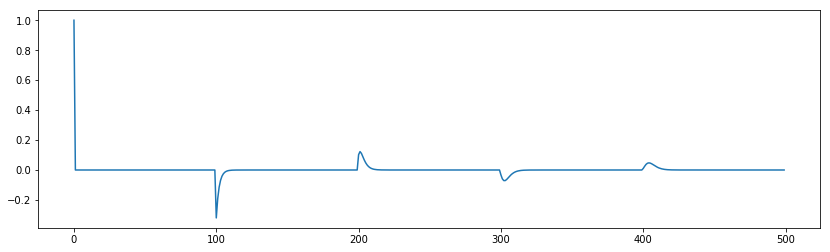

In [8]:
plt.plot(echo(delta(500), 100));

For audio signals, that's how the echo sounds for a delay to about 50ms

In [9]:
IPython.display.Audio(echo(s, int(0.050 * Fs)), rate=Fs)

Let's now implement the LMS filter for echo cancellation. Given the original signal $x[n]$ and its echo-corrupted version $d[n] = h[n] \ast x[n]$, the LMS algorithm will estimate $h[n]$ iteratively as

\begin{align}
  e[n] &= d[n] - \mathbf{h}_{n}^{T} \mathbf{x}_n \\
  \mathbf{h}_{n+1} &= \mathbf{h}_n + \alpha_n\, e[n] \, \mathbf{x}_n
\end{align}

where $\mathbf{h}_n$ is the set of estimated filter coefficients at iteration $n$:
$$\mathbf{h}_n = \begin{bmatrix} h_n[0] & h_n[1] & h_n[2] & \ldots & h_n[N-1] \end{bmatrix}$$
and where
$$\mathbf{x}_n = \begin{bmatrix} x[n] & x[n-1] & x[n-2] & \ldots & x[n - N + 1] \end{bmatrix}$$

In [10]:
def lms(x, d, N, a=0.001):
    # Run the LMS adaptation using x as the input signal, d as the desired output signal and a as the step size
    # Will return an N-tap FIR filter
    #
    # initial guess for the filter is a delta
    h = delta(N)
    # number of iterations
    L = min(len(x), len(d))
    # let's store the error at each iteration to plot the MSE
    e = np.zeros(L)
    # run the adaptation
    for n in range(N, L):
        e[n] = d[n] - np.dot(h, x[n:n-N:-1])
        h = h + a * e[n] * x[n:n-N:-1]
    return h, e[N:]

Let's now test the LMS filter using unit-variance white Gaussian noise as the input signal. With this maximally decorrelated input the convergence is faster. First, let's verify that the filter converges to a good approximation of the echo's impulse response:

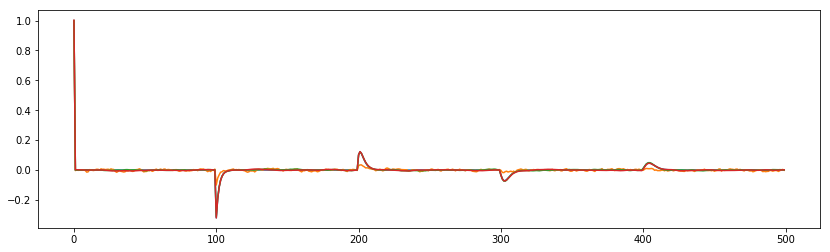

In [11]:
# echo delay
delay = 100

# LMS parameters
taps = 500
step_size = 0.0008

# this function generates runs the LMS adaptation on a signal of length L and returns the filter's coefficients
def test_lms(L):
    # the input signal
    ns = np.random.randn(L)
    return lms(ns, echo(ns, delay), taps, step_size)[0]
    
# precision increases with length of the adaptation 
plt.plot(echo(delta(taps), delay)); # original impulse response
plt.plot(test_lms(1000));
plt.plot(test_lms(5000));
plt.plot(test_lms(10000));


Clearly the precision depends on the number of steps in the adaptation. You can try and play with the value of the step size, for instance, and see how it affects the convergence.

To have a quantitative descrition of the convergence process we can plot the MSE, averaged over a number of independent experiments.

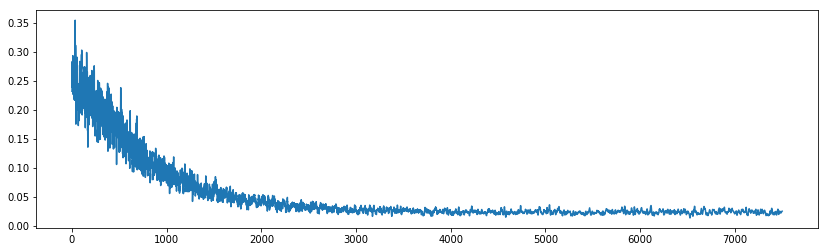

In [13]:
TRIALS = 100
L = 8000

for n in range(0, TRIALS):
    ns = np.random.randn(L)
    err = np.square(lms(ns, echo(ns, delay), taps, step_size)[1]) 
    if n == 0:
        mse = err
    else:
        mse = mse + err
mse = mse / TRIALS   
plt.plot(mse);

As you can see, with these parameters the error stops decreasing after about 4000 iterations. 

Let's now run the LMS adaptation using a voice signal as the input. Since the voice signal is very correlated, the convergenge will be slower, but we can use a much larger step size.

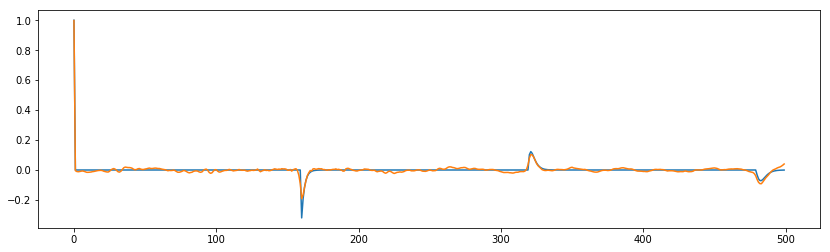

In [14]:
# let's build the echo signal with a 20ms delay
delay = int(0.020 * Fs)
es = echo(s, delay)

# now let's estimate the first 500 taps of the echo impulse response using the speech signal
taps = 500
step_size = 0.01

h, err = lms(s, es, taps, step_size)
plt.plot(echo(delta(taps), delay));
plt.plot(h);

You can see that, in spite of the almost 20 thousand iterations, the convergence is much less accurate than in the case of a white noise input. Nevertheless, the echo canceler does its job reasonably well, as illustrated by the magnitude of the error signal with respect to the echo signal:

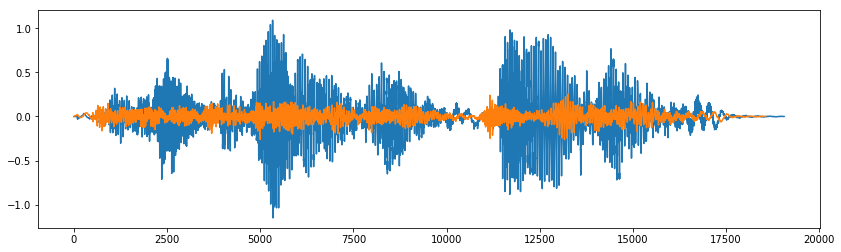

In [15]:
plt.plot(es);
plt.plot(err);